In [1]:
from dataclasses import dataclass

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# filter warnings
warnings.filterwarnings('ignore')

# Multiclass classification

## EDA

In [2]:
df = pd.read_csv('../data/Module_2_Lecture_2_Class_penguins.csv')

In [3]:
df.sample(5, random_state=42)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
194,Gentoo,Biscoe,45.3,13.7,210.0,4300.0,female
157,Gentoo,Biscoe,46.5,13.5,210.0,4550.0,female
225,Gentoo,Biscoe,46.5,14.8,217.0,5200.0,female
208,Gentoo,Biscoe,43.8,13.9,208.0,4300.0,female
318,Chinstrap,Dream,50.9,19.1,196.0,3550.0,male


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [5]:
df = df.dropna().reset_index(drop=True)

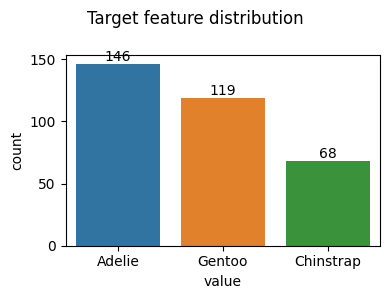

In [6]:
plt.figure(figsize=(4,3))
ax = sns.countplot(data=df, x='species')
for i in ax.containers:
    ax.bar_label(i)
    ax.set_xlabel("value")
    ax.set_ylabel("count")
            
plt.suptitle("Target feature distribution")

plt.tight_layout()
plt.show()

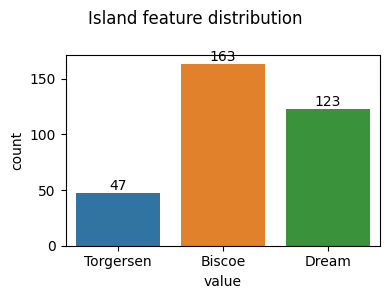

In [7]:
plt.figure(figsize=(4,3))
ax = sns.countplot(data=df, x='island')
for i in ax.containers:
    ax.bar_label(i)
    ax.set_xlabel("value")
    ax.set_ylabel("count")
            
plt.suptitle("Island feature distribution")

plt.tight_layout()
plt.show()

<Figure size 600x600 with 0 Axes>

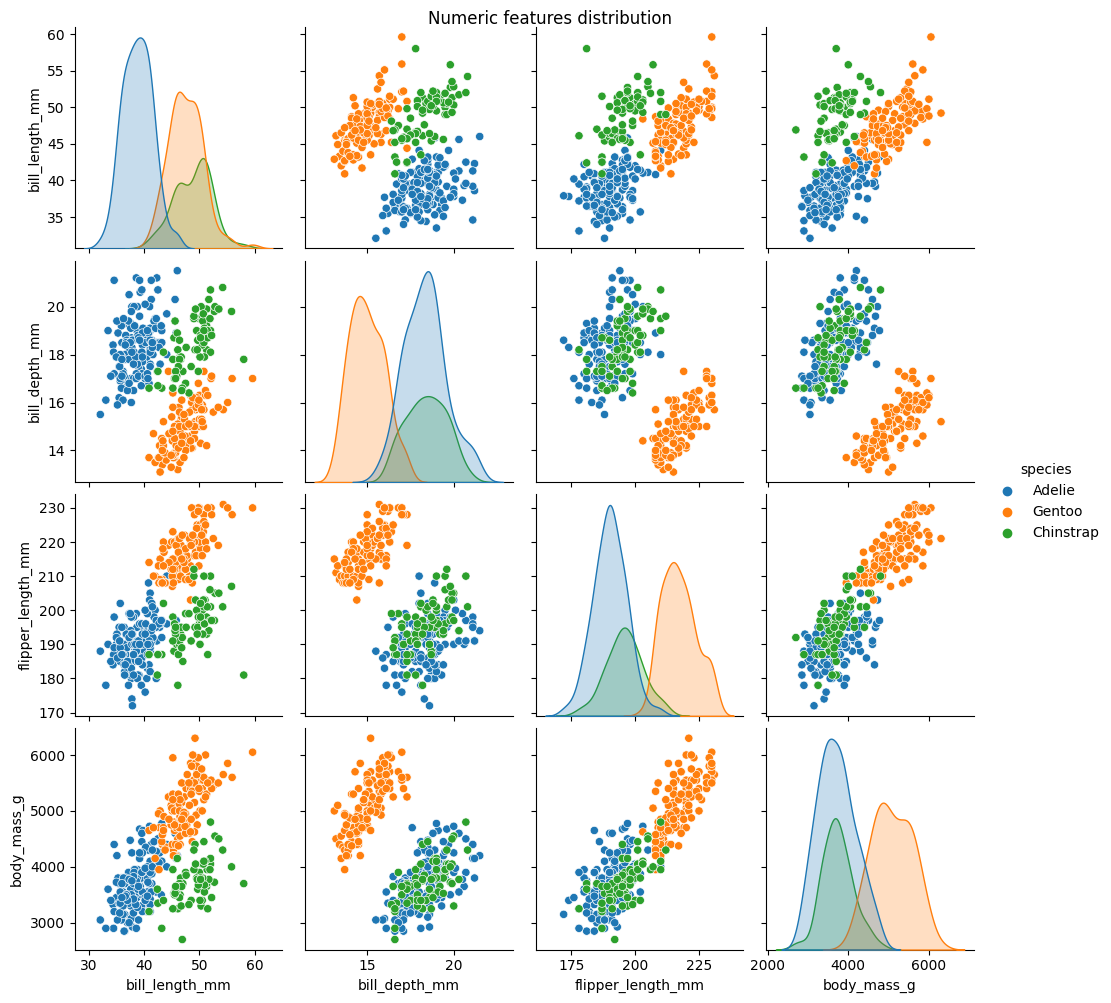

In [8]:
plt.figure(figsize=(6,6))
sns.pairplot(data=df, hue='species').fig.suptitle('Numeric features distribution', y=1)
plt.show()

## Feature preprocessing

In [9]:
features = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

In [10]:
df = df.loc[:, features]

In [11]:
df.loc[df['species']=='Adelie', 'species']=0
df.loc[df['species']=='Gentoo', 'species']=1
df.loc[df['species']=='Chinstrap', 'species']=2
df = df.apply(pd.to_numeric)

In [12]:
df.head(2)

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,0,39.1,18.7,181.0,3750.0
1,0,39.5,17.4,186.0,3800.0


In [13]:
# Train/test split

X = df.drop('species', axis =1).values
y = df['species'].values

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [15]:
X

array([[-0.89604189,  0.7807321 , -1.42675157, -0.56847478],
       [-0.82278787,  0.11958397, -1.06947358, -0.50628618],
       [-0.67627982,  0.42472926, -0.42637319, -1.1903608 ],
       ...,
       [ 1.02687621,  0.52644436, -0.56928439, -0.53738048],
       [ 1.24663828,  0.93330475,  0.64546078, -0.13315457],
       [ 1.13675725,  0.7807321 , -0.2120064 , -0.53738048]])

In [16]:
X_train , X_test , y_train , y_test = train_test_split(X, y, random_state = 42, test_size =0.33, stratify=y)

## Modeling

In [17]:
X_train = torch.Tensor(X_train).float()
y_train = torch.Tensor(y_train).long()

X_test = torch.Tensor(X_test).float()
y_test = torch.Tensor(y_test).long()

In [18]:
print(X_train[:1])
print(y_train[:10])

tensor([[ 1.2650,  0.9842, -0.3549, -0.8172]])
tensor([2, 0, 1, 1, 1, 2, 0, 1, 1, 0])


In [19]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=20, out_dim=3):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            
            nn.Linear(in_dim, hidden_dim),
            torch.nn.ReLU(),
            
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax()
        )    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [20]:
model = LinearModel(X_train.shape[1], 20, 3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epoch = 400 

train_loss = []
test_loss = []

train_accs = []
test_accs = []

for epoch in range(num_epoch):
    
    # train the model
    model.train()
    
    outputs = model(X_train)
    
    loss = criterion(outputs, y_train)    
    train_loss.append(loss.cpu().detach().numpy())
    
    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()
    
    acc = 100 * torch.sum(y_train==torch.max(outputs.data, 1)[1]).double() / len(y_train)
    train_accs.append(acc)
    
    if (epoch+1) % 10 == 0:
        print ('Epoch [%d/%d] Loss: %.4f   Acc: %.4f' 
                       %(epoch+1, num_epoch, loss.item(), acc.item()))
        
    # test the model
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        
        loss = criterion(outputs, y_test)
        test_loss.append(loss.cpu().detach().numpy())
        
        acc = 100 * torch.sum(y_test==torch.max(outputs.data, 1)[1]).double() / len(y_test)
        test_accs.append(acc)

Epoch [10/400] Loss: 1.1167   Acc: 26.0090
Epoch [20/400] Loss: 1.1071   Acc: 32.2870
Epoch [30/400] Loss: 1.0975   Acc: 34.9776
Epoch [40/400] Loss: 1.0878   Acc: 35.8744
Epoch [50/400] Loss: 1.0782   Acc: 35.8744
Epoch [60/400] Loss: 1.0685   Acc: 35.8744
Epoch [70/400] Loss: 1.0589   Acc: 36.7713
Epoch [80/400] Loss: 1.0492   Acc: 42.6009
Epoch [90/400] Loss: 1.0397   Acc: 52.0179
Epoch [100/400] Loss: 1.0301   Acc: 60.5381
Epoch [110/400] Loss: 1.0207   Acc: 67.2646
Epoch [120/400] Loss: 1.0113   Acc: 72.1973
Epoch [130/400] Loss: 1.0021   Acc: 74.4395
Epoch [140/400] Loss: 0.9929   Acc: 75.7848
Epoch [150/400] Loss: 0.9839   Acc: 76.2332
Epoch [160/400] Loss: 0.9750   Acc: 76.2332
Epoch [170/400] Loss: 0.9663   Acc: 76.6816
Epoch [180/400] Loss: 0.9577   Acc: 77.1300
Epoch [190/400] Loss: 0.9493   Acc: 77.1300
Epoch [200/400] Loss: 0.9410   Acc: 77.5785
Epoch [210/400] Loss: 0.9329   Acc: 77.5785
Epoch [220/400] Loss: 0.9250   Acc: 78.0269
Epoch [230/400] Loss: 0.9173   Acc: 78.47

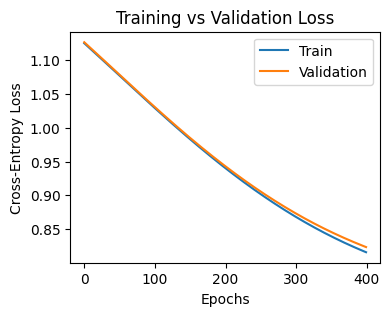

In [21]:
plt.figure(figsize=(4, 3))
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training vs Validation Loss')
plt.show()

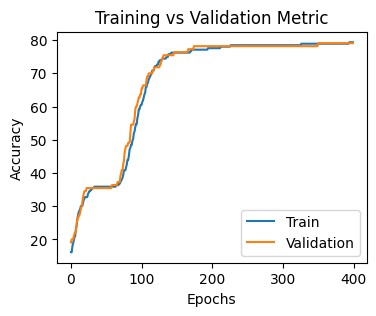

In [22]:
plt.figure(figsize=(4, 3))
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Metric')
plt.show()

# Regression

## Pre-processing

In [23]:
data_path = '../data/Module_2_Lecture_2_Class_bigmart_data.csv'

In [24]:
data = pd.read_csv(data_path)

In [25]:
data.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228


In [26]:
# Recreating preprocessing from the ML course

data['Outlet_Establishment_Year'] = 2013 - data['Outlet_Establishment_Year']
data['Item_Visibility'] = (data['Item_Visibility']
                           .mask(data['Item_Visibility'].eq(0), np.nan))

data['Item_Visibility_Avg'] = (data
                               .groupby(['Item_Type',
                                         'Outlet_Type'])['Item_Visibility']
                               .transform('mean'))

data['Item_Visibility'] = (
    data['Item_Visibility'].fillna(data['Item_Visibility_Avg']))

data['Item_Visibility_Ratio'] = (
    data['Item_Visibility'] / data['Item_Visibility_Avg'])

data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'})

data['Item_Identifier_Type'] = data['Item_Identifier'].str[:2]

In [27]:
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

In [28]:
# train/test split

X_train_num, X_test_num, X_train_cat,  X_test_cat, y_train, y_test = (
    train_test_split(
        data_num.drop(['Item_Outlet_Sales',
                       'Item_Visibility_Avg'], axis=1).values,
        data_cat.drop('Item_Identifier', axis=1).values,
        data['Item_Outlet_Sales'].values,
        test_size=0.2,
        random_state=42))

In [29]:
num_imputer = SimpleImputer().set_output(transform='pandas')

X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

In [30]:
cat_imputer = SimpleImputer(
    strategy='most_frequent').set_output(transform='pandas')

X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)

In [31]:
enc_auto = TargetEncoder(random_state=42).set_output(transform='pandas')

X_train_cat = enc_auto.fit_transform(X_train_cat, y_train)
X_test_cat = enc_auto.transform(X_test_cat)

In [32]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

## Modeling

In [33]:
# Making a PyTorch Dataset

class BigmartDataset(Dataset):
    def __init__(self, X, y, scale=True):        
        self.X = X.values # from Pandas DataFrame to NumPy array
        self.y = y
        
        if scale:
            sc = StandardScaler()
            self.X = sc.fit_transform(self.X)

    def __len__(self):
        #return size of a dataset
        return len(self.y)

    def __getitem__(self, idx):
        #supports indexing using dataset[i] to get the i-th row in a dataset
        
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)        
        
        return X, y

In [34]:
# Creating train and test datasets

train_dataset = BigmartDataset(X_train, y_train)
test_dataset = BigmartDataset(X_test, y_test)

# Loading Batches of Data

train_dataloader = DataLoader(train_dataset,
                              batch_size=200,
                              num_workers=4
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=200,
                              num_workers=4
                             )

In [35]:
next(iter(train_dataloader))

[tensor([[-0.8014, -0.7247,  0.4707,  ..., -1.4665,  0.1770,  0.6907],
         [ 1.2102, -0.4727,  0.4579,  ...,  0.7520,  0.1549, -1.0065],
         [ 1.1155,  0.1159, -0.4826,  ..., -1.6444,  0.1549,  0.7033],
         ...,
         [-0.1743, -1.0683,  1.7790,  ...,  0.3066, -0.2286,  0.1419],
         [ 0.7842, -0.5343, -1.5759,  ...,  0.5948,  0.1532,  0.4231],
         [-1.2013, -0.3088, -0.3086,  ...,  0.6938, -0.1931,  0.4231]]),
 tensor([2386.2273, 3103.9597, 1125.2020,  284.2966, 4224.5010,  447.4176,
          862.2110, 2269.0464,  639.1680, 9267.9355,  169.1132, 1162.4868,
          305.6022,  713.7376, 2061.3169, 3280.3965, 1402.1748,  487.3656,
         3029.3899, 1846.9292, 5494.8472, 1713.7692, 1332.2657, 2886.2429,
         2446.8149, 3952.1887, 2596.6201,  675.1212,  460.7336, 1911.5118,
          651.1524,   81.2276, 3901.5879, 4306.3945, 1669.8264, 2844.2976,
          705.7480, 3150.5657,  871.5322, 2966.1389, 2077.2959,  394.1536,
         7084.1118, 1451.4440, 12

In [36]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, 256),
            torch.nn.ReLU(),
            
            nn.Linear(256, 128),
            torch.nn.ReLU(),
            
            nn.Linear(128, 64),
            torch.nn.ReLU(),
            
            nn.Linear(64, out_dim),
        )
    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [37]:
# Initialize the model
model = LinearModel(in_dim=X_train.shape[1], out_dim=1)
  
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
train_rmses = []
test_losses = []
test_rmses = []

# Train the model

num_epochs = 100

for epoch in range(num_epochs):
    
    # Train step
    
    model.train()
    
    y_pred_train = []
    
    for data in train_dataloader:
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_train.extend(outputs.cpu().detach().numpy())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, RMSE: {RMSE(y_train, y_pred_train)}')
    train_rmses.append(RMSE(y_train, y_pred_train))
    train_losses.append(loss.cpu().detach().numpy())
    
    # Eval step
    
    model.eval()
    
    y_pred_test = []
    
    with torch.no_grad():
        
        for data in test_dataloader:
            # Get and prepare inputs
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # No backward pass
            
            y_pred_test.extend(outputs.cpu().detach().numpy())
        
        test_rmses.append(RMSE(y_test, y_pred_test))
        test_losses.append(loss.cpu().detach().numpy())
            

Epoch [10/100], Loss: 6551182.0000, RMSE: 2689.339607697705
Epoch [20/100], Loss: 2552465.2500, RMSE: 1798.789129175331
Epoch [30/100], Loss: 1361763.5000, RMSE: 1282.0699993301937
Epoch [40/100], Loss: 1199871.5000, RMSE: 1202.7805734329897
Epoch [50/100], Loss: 1094217.5000, RMSE: 1159.4636578785141
Epoch [60/100], Loss: 1030129.7500, RMSE: 1136.7514863662736
Epoch [70/100], Loss: 994814.2500, RMSE: 1125.694216205269
Epoch [80/100], Loss: 973953.5625, RMSE: 1119.8776790338675
Epoch [90/100], Loss: 961972.3125, RMSE: 1116.2153183135713
Epoch [100/100], Loss: 954619.1250, RMSE: 1113.3825327729812


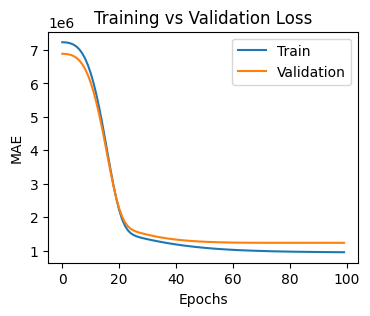

In [38]:
plt.figure(figsize=(4, 3))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training vs Validation Loss')
plt.show()

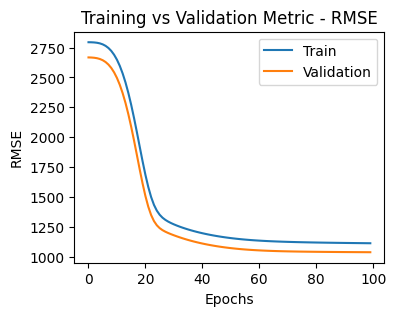

In [39]:
plt.figure(figsize=(4, 3))
plt.plot(train_rmses, label='Train')
plt.plot(test_rmses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training vs Validation Metric - RMSE')
plt.show()